# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn >= 0.20 and TensorFlow >= 2.0.

In [ ]:
# Python >= 3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


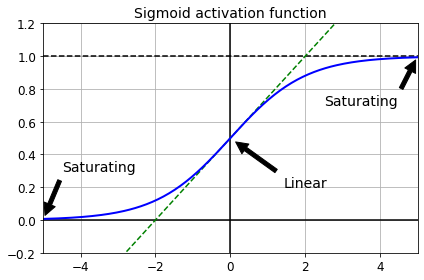

In [ ]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [ ]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [ ]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [ ]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Nonsaturating Activation Functions

### Leaky ReLU

In [ ]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


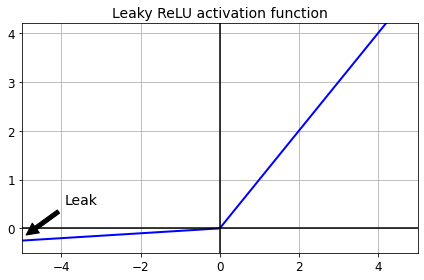

In [ ]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [ ]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [ ]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5338 - accuracy: 0.8223 - val_loss: 0.5157 - val_accuracy:

Now let's try PReLU:

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8184
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [ ]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


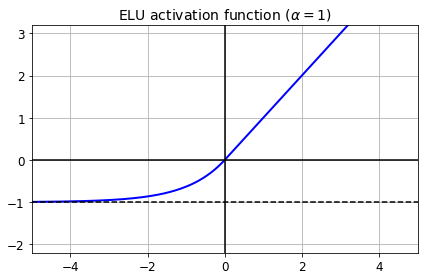

In [ ]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [ ]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [ ]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [ ]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


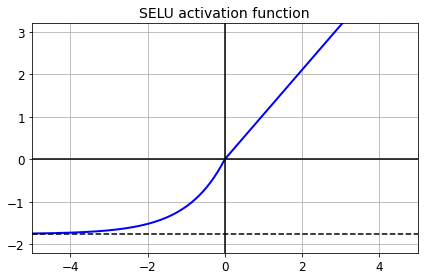

In [ ]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [ ]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [ ]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 35s 18ms/step - loss: 1.3126 - accuracy: 0.4951 - val_loss: 1.0706 - val_accuracy: 0.5906
Epoch 2/5
1719/1719 [==============================] - 30s 17ms/step - loss: 0.9123 - accuracy: 0.6536 - val_loss: 0.8169 - val_accuracy: 0.6684
Epoch 3/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.8725 - accuracy: 0.6685 - val_loss: 0.7552 - val_accuracy: 0.7070
Epoch 4/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.8291 - accuracy: 0.6922 - val_loss: 0.6890 - val_accuracy: 0.7562
Epoch 5/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.7144 - accuracy: 0.7379 - val_loss: 0.6470 - val_accuracy: 0.7704


Now look at what happens if we try to use the ReLU activation function instead:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 16ms/step - loss: 1.8088 - accuracy: 0.2686 - val_loss: 1.7779 - val_accuracy: 0.2616
Epoch 2/5
1719/1719 [==============================] - 26s 15ms/step - loss: 1.1340 - accuracy: 0.5239 - val_loss: 1.0905 - val_accuracy: 0.5316
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.1595 - accuracy: 0.5107 - val_loss: 0.9522 - val_accuracy: 0.5894
Epoch 4/5
1719/1719 [==============================] - 26s 15ms/step - loss: 0.9180 - accuracy: 0.6209 - val_loss: 0.8417 - val_accuracy: 0.6406
Epoch 5/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.8130 - accuracy: 0.6737 - val_loss: 0.7211 - val_accuracy: 0.7272


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [ ]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
#bn1.updates #deprecated

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5524 - val_accuracy: 0.8230
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5753 - accuracy: 0.8031 - val_loss: 0.4725 - val_accuracy: 0.8468
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5189 - accuracy: 0.8206 - val_loss: 0.4375 - val_accuracy: 0.8552
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4826 - accuracy: 0.8325 - val_loss: 0.4151 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4565 - accuracy: 0.8408 - val_loss: 0.3995 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4398 - accuracy: 0.8472 - val_loss: 0.3866 - val_accuracy: 0.8688
Epoch 7/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.4242 - accuracy: 0.8511 - val_loss: 0.3762 - val_accurac

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer has some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.0317 - accuracy: 0.6757 - val_loss: 0.6767 - val_accuracy: 0.7812
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5447 - accuracy: 0.8192 - val_loss: 0.4666 - val_accuracy: 0.8448
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.4434 - val_accuracy: 0.8536
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4898 - accuracy: 0.8338 - val_loss: 0.4262 - val_accuracy: 0.8546
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4712 - accuracy: 0.8396 - val_loss: 0.4130 - val_accur

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [ ]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

(43986, 28, 28)

In [ ]:
X_train_B.shape

(200, 28, 28)

In [ ]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [ ]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3890 - val_accuracy: 0.8677
Epoch 2/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3291 - val_accuracy: 0.8822
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3170 - accuracy: 0.8894 - val_loss: 0.3013 - val_accuracy: 0.8999
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2972 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9018
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2834 - accuracy: 0.9023 - val_loss: 0.2773 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2733 - val_accuracy: 0.9076
Epoch 7/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2641 - accuracy: 0.9091 - val_loss: 0.2720 - val_accuracy:

In [ ]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 74ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 34ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 47ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 39ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 34ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 22ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 28ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [ ]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [ ]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [ ]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 131ms/step - loss: 0.2654 - accuracy: 0.9400 - val_loss: 0.2794 - val_accuracy: 0.9280
Epoch 2/4
7/7 [==============================] - 0s 46ms/step - loss: 0.2556 - accuracy: 0.9400 - val_loss: 0.2698 - val_accuracy: 0.9331
Epoch 3/4
7/7 [==============================] - 0s 45ms/step - loss: 0.2462 - accuracy: 0.9400 - val_loss: 0.2610 - val_accuracy: 0.9351
Epoch 4/4
7/7 [==============================] - 0s 51ms/step - loss: 0.2376 - accuracy: 0.9400 - val_loss: 0.2528 - val_accuracy: 0.9361
Epoch 1/16
7/7 [==============================] - 1s 103ms/step - loss: 0.2128 - accuracy: 0.9450 - val_loss: 0.2049 - val_accuracy: 0.9645
Epoch 2/16
7/7 [==============================] - 0s 77ms/step - loss: 0.1703 - accuracy: 0.9550 - val_loss: 0.1723 - val_accuracy: 0.9716
Epoch 3/16
7/7 [==============================] - 0s 41ms/step - loss: 0.1411 - accuracy: 0.9650 - val_loss: 0.1495 - val_accuracy: 0.9817
Epoch 4/16
7/7 [=============

So, what's the final verdict?

In [ ]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407986164093, 0.9704999923706055]

In [ ]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0562 - accuracy: 0.9940


[0.056181780993938446, 0.9940000176429749]

Great! We got quite a bit of transfer: the error rate dropped by a factor of 4.9!

In [ ]:
(100 - 97.05) / (100 - 99.40)

4.916666666666718

# Faster Optimizers

## Momentum optimization

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [ ]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

In [ ]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam Optimization

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [ ]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

$$\eta(t) = \dfrac{\eta_0}{\left(1 + \dfrac{t}{s}\right)^c}$$

* Keras uses $c=1$ and `s = 1 / decay`

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4898 - accuracy: 0.8265 - val_loss: 0.4063 - val_accuracy: 0.8610
Epoch 2/25
1719/1719 [==============================] - 13s 8ms/step - loss: 0.3793 - accuracy: 0.8652 - val_loss: 0.3731 - val_accuracy: 0.8718
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3467 - accuracy: 0.8777 - val_loss: 0.3745 - val_accuracy: 0.8722
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3258 - accuracy: 0.8847 - val_loss: 0.3511 - val_accuracy: 0.8786
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3107 - accuracy: 0.8896 - val_loss: 0.3448 - val_accuracy: 0.8786
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2972 - accuracy: 0.8939 - val_loss: 0.3417 - val_accuracy: 0.8844
Epoch 7/25
1719/1719 [==============================] - 13s 7ms/step - loss: 0.2871 - accuracy: 0.8980 - val_loss: 0.3379 - val_accur

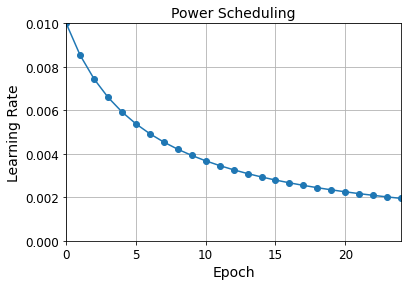

In [ ]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

$$\eta(t) = \eta_0\cdot 0.1^{t/s}$$

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8520 - accuracy: 0.7539 - val_loss: 1.0364 - val_accuracy: 0.7288 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6711 - accuracy: 0.7997 - val_loss: 0.8246 - val_accuracy: 0.8082 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5753 - accuracy: 0.8206 - val_loss: 0.6832 - val_accuracy: 0.8062 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5655 - accuracy: 0.8287 - val_loss: 0.5217 - val_accuracy: 0.8330 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4831 - accuracy: 0.8490 - val_loss: 0.5566 - val_accuracy: 0.8558 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4433 - accuracy: 0.8590 - val_loss: 0.5107 - val_accuracy: 0.8522 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

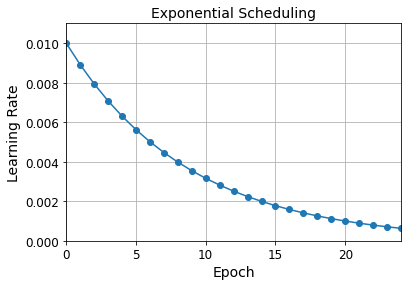

In [ ]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [ ]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7677 - accuracy: 0.7725 - val_loss: 0.8305 - val_accuracy: 0.7626 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6341 - accuracy: 0.8052 - val_loss: 0.5845 - val_accuracy: 0.8136 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5647 - accuracy: 0.8243 - val_loss: 0.5743 - val_accuracy: 0.8236 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5512 - accuracy: 0.8310 - val_loss: 0.5167 - val_accuracy: 0.8176 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4752 - accuracy: 0.8497 - val_loss: 0.5107 - val_accuracy: 0.8642 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 19s 11ms/step - loss: 0.4148 - accuracy: 0.8681 - val_loss: 0.4661 - val_accuracy: 0.8658 - lr: 0.0050
Epoch 7/25
1719/1719 [=============================

In [ ]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

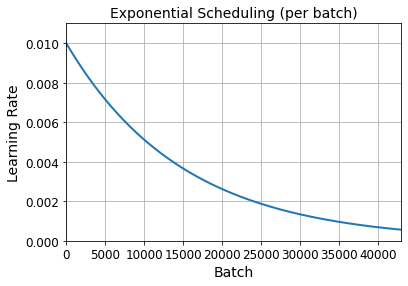

In [ ]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [ ]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.8439 - accuracy: 0.7565 - val_loss: 0.8615 - val_accuracy: 0.7550 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8937 - accuracy: 0.7437 - val_loss: 0.7484 - val_accuracy: 0.7432 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 1.0008 - accuracy: 0.6805 - val_loss: 1.5534 - val_accuracy: 0.6090 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 1.1070 - accuracy: 0.6275 - val_loss: 1.3036 - val_accuracy: 0.5442 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 1.2505 - accuracy: 0.5916 - val_loss: 1.5156 - val_accuracy: 0.5850 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8833 - accuracy: 0.6522 - val_loss: 0.9401 - val_accuracy: 0.6704 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

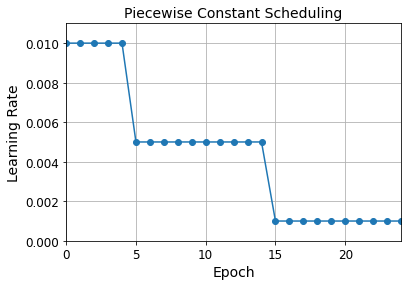

In [ ]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5904 - accuracy: 0.8058 - val_loss: 0.4759 - val_accuracy: 0.8480 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4946 - accuracy: 0.8404 - val_loss: 0.5246 - val_accuracy: 0.8340 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5096 - accuracy: 0.8422 - val_loss: 0.4641 - val_accuracy: 0.8612 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5048 - accuracy: 0.8469 - val_loss: 0.5777 - val_accuracy: 0.8232 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5286 - accuracy: 0.8476 - val_loss: 0.4906 - val_accuracy: 0.8536 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5237 - accuracy: 0.8503 - val_loss: 0.5818 - val_accuracy: 0.8624 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 6s

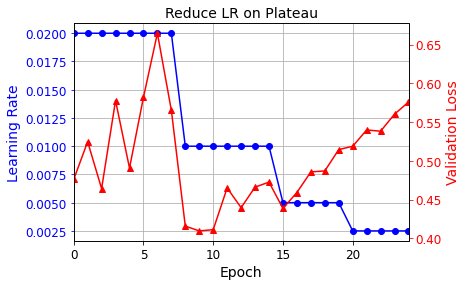

In [ ]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4893 - accuracy: 0.8275 - val_loss: 0.4092 - val_accuracy: 0.8602
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3819 - accuracy: 0.8649 - val_loss: 0.3739 - val_accuracy: 0.8690
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3487 - accuracy: 0.8766 - val_loss: 0.3736 - val_accuracy: 0.8676
Epoch 4/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3265 - accuracy: 0.8834 - val_loss: 0.3493 - val_accuracy: 0.8804
Epoch 5/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3104 - accuracy: 0.8895 - val_loss: 0.3430 - val_accuracy: 0.8788
Epoch 6/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2958 - accuracy: 0.8950 - val_loss: 0.3412 - val_accuracy: 0.8802
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2854 - accuracy: 0.8987 - val_loss: 0.3352 - val_accuracy:

For piecewise constant scheduling, try this:

In [ ]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [ ]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**Warning**: In the `on_batch_end()` method, `logs["loss"]` used to contain the batch loss, but in TensorFlow 2.2.0 it was replaced with the mean loss (since the start of the epoch). This explains why the graph below is much smoother than in the book (if you are using TF 2.2 or above). It also means that there is a lag between the moment the batch loss starts exploding and the moment the explosion becomes clear in the graph. So you should choose a slightly smaller learning rate than you would have chosen with the "noisy" graph. Alternatively, you can tweak the `ExponentialLearningRate` callback above so it computes the batch loss (based on the current mean loss and the previous mean loss):

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
```

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 5ms/step - loss: nan - accuracy: 0.3855


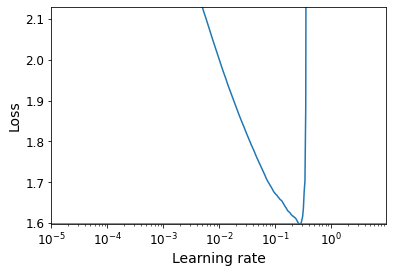

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [ ]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8524
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4122 - accuracy: 0.8546 - val_loss: 0.4115 - val_accuracy: 0.8584
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3868 - val_accuracy: 0.8688
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3639 - accuracy: 0.8716 - val_loss: 0.3766 - val_accuracy: 0.8680
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3457 - accuracy: 0.8774 - val_loss: 0.3742 - val_accuracy: 0.8710
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3330 - accuracy: 0.8807 - val_loss: 0.3635 - val_accuracy: 0.8706
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5838 - accuracy: 0.7997 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4209 - accuracy: 0.8442 - val_loss: 0.3397 - val_accuracy: 0.8716


## Alpha Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6617 - accuracy: 0.7611 - val_loss: 0.5777 - val_accuracy: 0.8410
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5548 - accuracy: 0.7966 - val_loss: 0.5403 - val_accuracy: 0.8480
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5259 - accuracy: 0.8063 - val_loss: 0.4997 - val_accuracy: 0.8552
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5050 - accuracy: 0.8126 - val_loss: 0.4763 - val_accuracy: 0.8622
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4925 - accuracy: 0.8171 - val_loss: 0.4592 - val_accuracy: 0.8636
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4837 - accuracy: 0.8198 - val_loss: 0.4856 - val_accuracy: 0.8566
Epoch 7/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4709 - accuracy: 0.8250 - val_loss: 0.5037 - val_accuracy:

In [ ]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4627 - accuracy: 0.8604


[0.4626573622226715, 0.8604000210762024]

In [ ]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3372 - accuracy: 0.8837


[0.3371737599372864, 0.8836727142333984]

In [ ]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 6s 3ms/step - loss: 0.4201 - accuracy: 0.8433


## MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

NameError: name 'np' is not defined

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],
      dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.57, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.93, 0.  , 0.05]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.46, 0.  , 0.53]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.24]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.43, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.28, 0.  , 0.59]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.06, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.07, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.28, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.29, 0.  , 0.7 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.22, 0.  , 0

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.22, 0.  , 0.68]],
      dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.24, 0.  , 0.29]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8661

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 784)               0         
_________________________________________________________________
mc_alpha_dropout (MCAlphaDro (None, 784)               0         
_________________________________________________________________
dense_262 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_alpha_dropout_1 (MCAlphaD (None, 300)               0         
_________________________________________________________________
dense_263 (Dense)            (None, 100)               30100     
_________________________________________________________________
mc_alpha_dropout_2 (MCAlphaD (None, 100)               0         
_________________________________________________________________
dense_264 (Dense)            (None, 10)              

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.25, 0.01, 0.61]],
      dtype=float32)

## Max norm

In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5763 - accuracy: 0.8020 - val_loss: 0.3674 - val_accuracy: 0.8674
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3545 - accuracy: 0.8709 - val_loss: 0.3714 - val_accuracy: 0.8662


# Exercises

## 1. to 7.

See appendix A.

1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?


No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It’s like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.

2. Is it OK to initialize the bias terms to 0?

It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that’s okay too; it does not make much difference.

3. Name three advantages of the SELU activation function over ReLU.


A few advantages of the SELU function over the ReLU function are:
- It can take on negative values, so the average output of the neurons in any given layer is typically closer to zero than when using the ReLU activation function (which never outputs negative values). This helps alleviate the vanishing gradients problem.
- It always has a nonzero derivative, which avoids the dying units issue that can affect ReLU units. 
- When the conditions are right (i.e., if the model is sequential, and the weights are initialized using LeCun initialization, and the inputs are standardized, and there’s no incompatible layer or regularization, such as dropout or $l_1$ regularization), then the SELU activation function ensures the model is self-normalized, which solves the exploding/vanishing gradients problems.


4. In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?

The SELU activation function is a good default. If you need the neural network to be as fast as possible, you can use one of the leaky ReLU variants instead (e.g., a simple leaky ReLU using the default hyperparameter value). The simplicity of the ReLU activation function makes it many people’s preferred option, despite the fact that it is generally outperformed by SELU and leaky ReLU. However, the ReLU activation function’s ability to output precisely zero can be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from  optimized implementation as well as from hardware acceleration. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number between –1 and 1, but nowadays it is not used much in hidden layers (except in recurrent nets). The logistic activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). Finally, the softmax activation function is useful in the output layer to output probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.


5. What may happen if you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer?

If you set the momentum hyperparameter too close to 1 (e.g., 0.99999) when using an SGD optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller momentum value.

6. Name three ways you can produce a sparse model.


One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply $l_1$ regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.

7. Does dropout slow down training? Does it slow down inference (i.e., making predictions on new instances)? What about MC Dropout?


Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.


8. Practice training a deep neural network on the CIFAR10 image dataset:
    - Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function.
    - Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_ data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.
    - Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?
    - Try replacing Batch Normalization with SELU, and  make the necessary adjustements to ensure the network self normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).
    - Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout. 
    - Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [ ]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
E0213 19:12:55.493896 4621630912 program.py:311] TensorBoard could not bind to port 6006, it was already in use
ERROR: TensorBoard could not bind to port 6006, it was already in use

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 9s 5ms/step - loss: 9.4191 - accuracy: 0.1388 - val_loss: 2.2328 - val_accuracy: 0.2040
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 2.1097 - accuracy: 0.2317 - val_loss: 2.0485 - val_accuracy: 0.2402
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.9667 - accuracy: 0.2844 - val_loss: 1.9681 - val_accuracy: 0.2964
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8740 - accuracy: 0.3149 - val_loss: 1.9178 - val_accuracy: 0.3254
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.8064 - accuracy: 0.3423 - val_loss: 1.8256 - val_accuracy: 0.3384
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7525 - accuracy: 0.3595 - val_loss: 1.7430 - val_accuracy: 0.3692
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7116 - accuracy: 0.3819 - val_loss: 1.7199 - val_ac

In [ ]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.4960 - accuracy: 0.4762


[1.4960416555404663, 0.47620001435279846]

The model with the lowest validation loss gets about 47.6% accuracy on the validation set. It took 27 epochs to reach the lowest validation loss, with roughly 8 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 19s 9ms/step - loss: 1.9765 - accuracy: 0.2968 - val_loss: 1.6602 - val_accuracy: 0.4042
Epoch 2/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.6787 - accuracy: 0.4056 - val_loss: 1.5887 - val_accuracy: 0.4304
Epoch 3/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.6097 - accuracy: 0.4274 - val_loss: 1.5781 - val_accuracy: 0.4326
Epoch 4/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5574 - accuracy: 0.4486 - val_loss: 1.5064 - val_accuracy: 0.4676
Epoch 5/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.5075 - accuracy: 0.4642 - val_loss: 1.4412 - val_accuracy: 0.4844
Epoch 6/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4664 - accuracy: 0.4787 - val_loss: 1.4179 - val_accuracy: 0.4984
Epoch 7/100
1407/1407 [==============================] - 11s 8ms/step - loss: 1.4334 - accuracy: 0.4932 - val_loss: 1.4277 -

[1.3343921899795532, 0.5397999882698059]

* *Is the model converging faster than before?* Much faster! The previous model took 27 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 5 epochs and continued to make progress until the 16th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 54.0% accuracy instead of 47.6%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 12s instead of 8s, because of the extra computations required by the BN layers. But overall the training time (wall time) was shortened significantly!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 10s 5ms/step - loss: 2.0622 - accuracy: 0.2631 - val_loss: 1.7878 - val_accuracy: 0.3552
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.7328 - accuracy: 0.3830 - val_loss: 1.7028 - val_accuracy: 0.3828
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.6342 - accuracy: 0.4279 - val_loss: 1.6692 - val_accuracy: 0.4022
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5524 - accuracy: 0.4538 - val_loss: 1.6350 - val_accuracy: 0.4300
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4979 - accuracy: 0.4756 - val_loss: 1.5773 - val_accuracy: 0.4356
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4428 - accuracy: 0.4902 - val_loss: 1.5529 - val_accuracy: 0.4630
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3966 - accuracy: 0.5126 - val_loss: 1.5290 - val_a

[1.4633383750915527, 0.47920000553131104]

In [ ]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 0s 1ms/step - loss: 1.4633 - accuracy: 0.4792


[1.4633383750915527, 0.47920000553131104]

We get 47.9% accuracy, which is not much better than the original model (47.6%), and not as good as the model using batch normalization (54.0%). However, convergence was almost as fast as with the BN model, plus each epoch took only 7 seconds. So it's by far the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 9s 5ms/step - loss: 2.0583 - accuracy: 0.2742 - val_loss: 1.7429 - val_accuracy: 0.3858
Epoch 2/100
1407/1407 [==============================] - 6s 5ms/step - loss: 1.6852 - accuracy: 0.4008 - val_loss: 1.7055 - val_accuracy: 0.3792
Epoch 3/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5963 - accuracy: 0.4413 - val_loss: 1.7401 - val_accuracy: 0.4072
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.5231 - accuracy: 0.4634 - val_loss: 1.5728 - val_accuracy: 0.4584
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 1.4619 - accuracy: 0.4887 - val_loss: 1.5448 - val_accuracy: 0.4702
Epoch 6/100
1407/1407 [==============================] - 6s 5ms/step - loss: 1.4074 - accuracy: 0.5061 - val_loss: 1.5678 - val_accuracy: 0.4664
Epoch 7/100
1407/1407 [==============================] - 6s 5ms/step - loss: 1.3718 - accuracy: 0.5222 - val_loss: 1.5764 - val_ac

[1.4804893732070923, 0.48899999260902405]

The model reaches 48.9% accuracy on the validation set. That's very slightly better than without dropout (47.6%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.4892

We get no accuracy improvement in this case (we're still at 48.9% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 2s 6ms/step - loss: nan - accuracy: 0.1255


(9.999999747378752e-06,
 9.999868392944336,
 2.6167492866516113,
 3.9354368618556435)

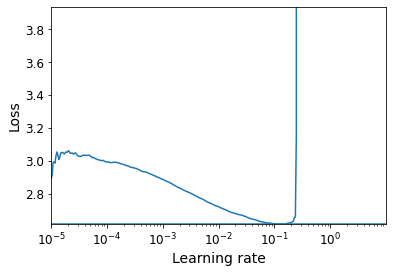

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(learning_rate=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
onecycle = OneCycleScheduler(math.ceil(len(X_train_scaled) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 6ms/step - loss: 2.2298 - accuracy: 0.2349 - val_loss: 1.7841 - val_accuracy: 0.3834
Epoch 2/15
352/352 [==============================] - 2s 6ms/step - loss: 1.7928 - accuracy: 0.3689 - val_loss: 1.6806 - val_accuracy: 0.4086
Epoch 3/15
352/352 [==============================] - 2s 6ms/step - loss: 1.6475 - accuracy: 0.4190 - val_loss: 1.6378 - val_accuracy: 0.4350
Epoch 4/15
352/352 [==============================] - 2s 6ms/step - loss: 1.5428 - accuracy: 0.4543 - val_loss: 1.6266 - val_accuracy: 0.4390
Epoch 5/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4865 - accuracy: 0.4769 - val_loss: 1.6158 - val_accuracy: 0.4384
Epoch 6/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4339 - accuracy: 0.4866 - val_loss: 1.5850 - val_accuracy: 0.4412
Epoch 7/15
352/352 [==============================] - 2s 6ms/step - loss: 1.4042 - accuracy: 0.5056 - val_loss: 1.6146 - val_accuracy: 0.4384
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 47.6% to 52.0%). The batch normalized model reaches a slightly better performance (54%), but it's much slower to train.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8b8747e0-d5e2-4759-af6a-42b7fe569db7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>